# Tutorial 11 - Neural Networks 2

## Keras Diagnostics 

Often it is useful to review what occured during training a neural network.

Whenever you call fit() on a keras model it returns a history object. Inside the history object is a history dictionary that contains arrays of various values. By default there is only one value, the loss, which is recorded for each iteration. If you add other metrics to the metrics parameter of the compile() function those will also be calculated per iteration and available in the history object.

In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense
from keras.models import Sequential

np.random.seed(0)

X, y = make_regression(n_samples = 100, n_features = 2, bias = 1.5 )

scaler = MinMaxScaler(feature_range=(0, 1))

X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))

model = Sequential()

n_features = X.shape[1]

model.add(Dense(1, input_dim=n_features, activation='linear', use_bias=True))

model.compile(loss='mean_squared_error', optimizer='adam')

# Alternative if you want to record other metrics in history e.g. accuracy or mean absolute error
# https://keras.io/metrics/
# model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy', 'mae'])

history = model.fit(X, y,  epochs=400, batch_size=16, verbose=2, validation_split=0)

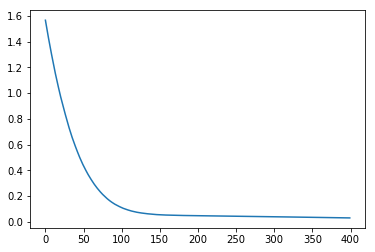

In [2]:
import matplotlib.pyplot as plt

loss_list = history.history['loss']

fig = plt.figure()
plt.plot(loss_list)
fig

## Effect of Batch Size

The batch size refers to the number of samples used in each forward/backward pass of the network.

To complete an Epoch you must use every training sample. So if you have 100 training samples and a batch size of 1 you must do 100 forward/backward passes per Epoch.

Generally a lower batch size will leave to greater minimisation per Epoch. In other words the batch size influences the step size or learning rate of our gradient descent. The step size is inversely proportional the batch size. If the batch size goes up then the step size goes down.

However a lower batch size takes more time as there is significiantly more overhead in training with many small batches than a few large batches.

Let's look at an example using the Advertising dataset.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("Advertising.csv", index_col=0)

df.head()

scaler = MinMaxScaler(feature_range=(0, 1))

data = scaler.fit_transform(df.values)

df_scaled = pd.DataFrame(data, columns=df.columns)

df_scaled.head()

y = df_scaled["Sales"]
X = df_scaled[ df_scaled.columns.difference(["Sales"]) ]

X_train, X_test, y_train, y_test = train_test_split(X, y)

n_features = X_train.shape[1]

Now that we have handled our data let's build a linear regression network and use a small batch size.

We want to understand the effect of batch size on how quickly we find the optimal parameters.

So we will record the parameter/weights at each training iteration. Fortunately keras allows you to train a few Epochs at a time then resume training!

In [ ]:
model_s = Sequential()
model_s.add(Dense(1, input_dim=n_features, activation='linear', use_bias=True))
model_s.compile(loss='mean_squared_error', optimizer='adam')

n_epochs = 400

weights_wrt_is = np.zeros( (n_epochs, 4) )
batch_s = 1

history = None
for i in range(n_epochs):
    if history:
        history = model_s.fit(X_train.values, y_train.values,  epochs= i+1, initial_epoch=i, batch_size=batch_s, verbose=2, validation_split=0)
    else:
        history = model_s.fit(X_train.values, y_train.values,  epochs=1+1, batch_size=batch_s, verbose=2, validation_split=0)
        
    weights = model_s.layers[0].get_weights()
    weights_wrt_is[i, :] =  np.concatenate( (weights[1], weights[0][:,0]) , axis = 0 )



Let's plot $\beta_0$ vs Epochs. **Notice that the weights converge very quickly.**

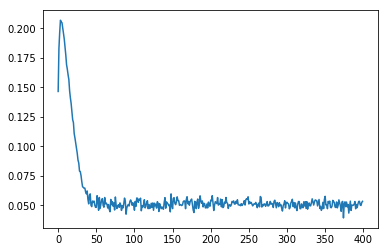

In [5]:
fig = plt.figure()

plt.plot(weights_wrt_is[:, 0])

fig

Now let's try with a bigger batch size.

Remember that batch sizes should always be a power of 2 to take best advantage of your computers parallelisation abilities!

In [ ]:
model_l = Sequential()
model_l.add(Dense(1, input_dim=n_features, activation='linear', use_bias=True))
model_l.compile(loss='mean_squared_error', optimizer='adam')

weights_wrt_il = np.zeros( (n_epochs, 4) )
batch_l = 32

history = None
for i in range(n_epochs):
    if history:
        history = model_l.fit(X_train.values, y_train.values,  epochs= i+1, initial_epoch=i, batch_size=batch_l, verbose=2, validation_split=0)
    else:
        history = model_l.fit(X_train.values, y_train.values,  epochs=1+1, batch_size=batch_l, verbose=2, validation_split=0)
        
    weights = model_l.layers[0].get_weights()
    weights_wrt_il[i, :] =  np.concatenate( (weights[1], weights[0][:,0]) , axis = 0 )

Again let's look at $\beta_0$. Notice that it takes much longer to converge!

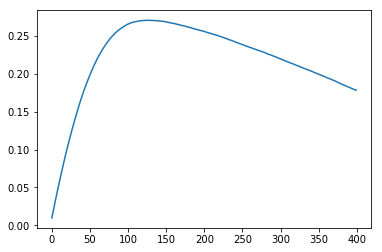

In [7]:
fig = plt.figure()

plt.plot(weights_wrt_il[:, 0])

fig

Finally lets compare all of the coefficients/weights that we estimated

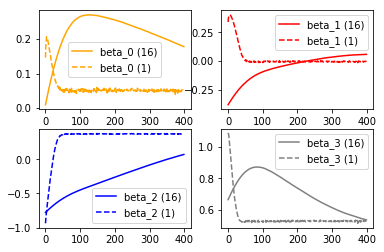

In [8]:
labels = ['beta_0', 'beta_1', 'beta_2', 'beta_3']
colors = ['orange', 'red', 'blue', 'grey']

fig, axarr = plt.subplots(2, 2)

axarr = np.ravel(axarr)

for i in range(4):
    axarr[i].plot(weights_wrt_il[:, i], label = "{0} (16)".format(labels[i]), c = colors[i], linestyle = "solid" )
    axarr[i].plot(weights_wrt_is[:, i], label = "{0} (1)".format(labels[i]), c = colors[i], linestyle = "dashed")
    axarr[i].legend()

fig

## Time Series

For time series models we need a special layer type. We need a reccurrent layer, that is a layer that uses information from previous time points.

We also need to do some feature engineering. If we want to predict the next item in a sequence we need to observe the sequence i.e. if we want to predict $y_{t+1}$ we need $[y_{t-d}, \dots, y_{t-2}, y_{t-1}, y_t]$.

For our training data we need to do this for every training sample.

### What value should we use for $d$?

A good practice is to set $d$ to be greater than or equal to the maximum size of any cyclic, seasonal or repeated behaviour that is exhibited in your time series. If it is shorter than that it may not be able to accurately model the behaviour.

### Example

To illustrate lets create some sinusoidal data to practice on!

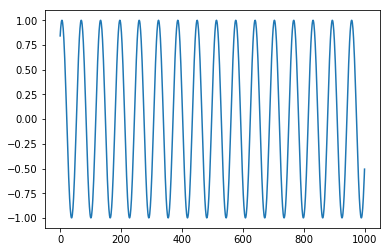

In [9]:
from keras.layers.recurrent import LSTM
from keras.layers.core import Activation
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, display

np.random.seed(0)

# Create the data
n_points = 1000

data_x = np.linspace(1, 100, n_points)
data = np.sin(data_x)

# Plot the data
fig = plt.figure()
plt.plot(data)
fig

Now let's generate all the features we are going to use as discussed above!

In [10]:
time_window = 100

Xall, Yall = [], []

for i in range(time_window, len(data)):
    Xall.append(data[i-time_window:i])
    Yall.append(data[i])
Xall = np.array(Xall)    # Convert them from list to array   
Yall = np.array(Yall)

train_size = int(len(Xall) * 0.8)
test_size = len(Xall) - train_size

Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]

Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

# For time series and LSTM layer we need to reshape into 3D array
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], time_window, 1))  
Xtest = np.reshape(Xtest, (Xtest.shape[0], time_window, 1))  

Now we will define a simple Reccurent Neural Network. There are many types of Recurrent layers, but we will use the Long-Short Term Memory layer type.

This layer type is a layer with "cells" (a more complex neuron) that accepts input from the previous cell and input from many of the past cells.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" style="width: 400px;"/>

*image from http://colah.github.io/posts/2015-08-Understanding-LSTMs/*

Number of cells is the same as your data size. For example if use the past 10 observations to predict a new observation then the number of LSTM cells is also 10.

Units is the dimension of vector of hidden state, cycle state and the final output size.

In [11]:
model = Sequential()

model.add(LSTM(units=50, input_shape=(None, 1), return_sequences=False))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="rmsprop")

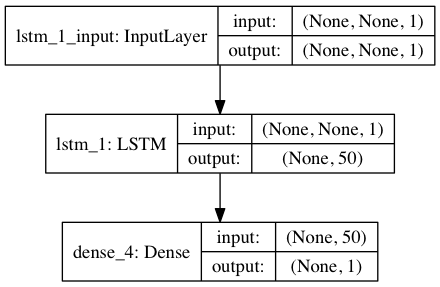

In [12]:
dot_obj = model_to_dot(model, show_shapes = True, show_layer_names = True)

display(Image(dot_obj.create_png()))

In [ ]:
# Training
model.fit(Xtrain, Ytrain, batch_size=100, nb_epoch=100, validation_split=0)

Let's now plot our prediction and the ground truth.

To predict the forecast we must repeatedly to predictions, one at a time. After ech prediction we add our previous prediction to our data and predict again.

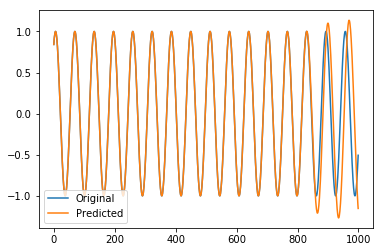

In [14]:
dynamic_prediction = np.copy(data[:len(data) - test_size])

for i in range(len(data) - test_size, len(data)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window,1))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

dynamic_prediction = dynamic_prediction.reshape(-1,1)

fig = plt.figure()
plt.plot(data, label = "Original")
plt.plot(dynamic_prediction, label = "Predicted")
plt.legend(loc="lower left")
fig